# 01 – Preselect & Diagnostics (CAPE / CIN / Shear)
This notebook **does not run WRF**. It reads soundings from your Sobol experiment, computes diagnostics (CAPE, CIN, 0–1 km and 0–6 km bulk shear, PW), and visualizes **ranges and coverage**.

**Modes:**
1. *Generate mode*: Generate soundings on-the-fly using Sobol samples
2. *Folder mode*: Read existing WRF-ready `input_sounding_*` files from step2 output
3. *Diagnostics mode*: Load pre-computed diagnostics from step2

The goal is to explore **full distributions** – not just a low‑CAPE/high‑shear subset.

In [102]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import pickle

# Add src to path
REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.insert(0, str(SRC))

# Import your sounding generator
from sounding_generator import (
    generate_sounding,
    calculate_cape_cin,
    read_input_sounding as read_wrf_sounding
)

In [103]:
# --- CONFIG ---
MODE = 'diagnostics'   # 'generate', 'folder', or 'diagnostics'

# For 'generate' mode: path to your Sobol experiment
EXPERIMENT_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_500')
BASE_SOUNDING = str(SRC / 'input_sounding')  # Your base sounding file
N_SAMPLES = 500  # How many samples to generate (for testing)

# For 'folder' mode: directory with input_sounding_* files
SOUNDINGS_DIR = str(REPO_ROOT / 'outputs' / 'sobol_exp_500' / 'soundings')

# For 'diagnostics' mode: path to diagnostics.pkl from step2
DIAGNOSTICS_PKL = str(REPO_ROOT / 'outputs' / 'sobol_exp_500' / 'soundings' / 'diagnostics.pkl')

# Output
OUT_CATALOG = str(REPO_ROOT / 'outputs' / 'env_catalog.csv')
os.makedirs(Path(OUT_CATALOG).parent, exist_ok=True)

In [104]:
# --- Build diagnostics catalog ---
rows = []

if MODE == 'generate':
    print(f"Generating {N_SAMPLES} soundings from Sobol samples...")
    
    # Load Sobol experiment
    with open(f'{EXPERIMENT_DIR}/problem.pkl', 'rb') as f:
        problem = pickle.load(f)
    param_values = np.load(f'{EXPERIMENT_DIR}/param_values.npy')
    
    # Generate subset of soundings
    n_process = min(N_SAMPLES, len(param_values))
    for i in range(n_process):
        param_dict = dict(zip(problem['names'], param_values[i]))
        
        try:
            sounding = generate_sounding(param_dict, base_sounding_file=BASE_SOUNDING)
            diag = compute_diagnostics(sounding)
            rows.append({'idx': i, **diag})
            
            if (i + 1) % 50 == 0:
                print(f"  Progress: {i+1}/{n_process}")
        except Exception as e:
            print(f"  ERROR: Sample {i} failed: {e}")
            rows.append({'idx': i, 'MLCAPE': np.nan, 'MLCIN': np.nan, 
                        'SH01': np.nan, 'SH03': np.nan, 'SH06': np.nan, 'PW': np.nan})

elif MODE == 'folder':
    print(f"Reading soundings from {SOUNDINGS_DIR}...")
    files = sorted(glob.glob(os.path.join(SOUNDINGS_DIR, 'input_sounding_*')))
    if not files:
        raise SystemExit(f'No input_sounding_* files found in {SOUNDINGS_DIR}')
    
    print(f"Found {len(files)} sounding files")
    for i, fp in enumerate(files):
        try:
            sounding = read_wrf_sounding(fp)
            diag = compute_diagnostics(sounding)
            rows.append({'idx': i, **diag})
            
            if (i + 1) % 100 == 0:
                print(f"  Progress: {i+1}/{len(files)}")
        except Exception as e:
            print(f"  ERROR: File {fp} failed: {e}")
            rows.append({'idx': i, 'MLCAPE': np.nan, 'MLCIN': np.nan,
                        'SH01': np.nan, 'SH03': np.nan, 'SH06': np.nan, 'PW': np.nan})

elif MODE == 'diagnostics':
    print(f"Loading pre-computed diagnostics from {DIAGNOSTICS_PKL}...")
    with open(DIAGNOSTICS_PKL, 'rb') as f:
        diag_dict = pickle.load(f)
    
    # Convert to format expected by notebook
    for i in range(len(diag_dict['sample_id'])):
        rows.append({
            'idx': diag_dict['sample_id'][i],
            'MUCAPE': diag_dict['mucape'][i],
            'MUCIN': diag_dict['mucin'][i],
            'SH01': diag_dict['shear_0_1km'][i],
            'SH03': diag_dict['shear_0_3km'][i],
            'SH06': diag_dict['shear_0_6km'][i],
            'PW': diag_dict['pwat'][i]
        })

else:
    raise ValueError(f'Unknown MODE: {MODE}')

df = pd.DataFrame(rows)
df.to_csv(OUT_CATALOG, index=False)
print(f"\nSaved catalog to {OUT_CATALOG}")
print(f"\nDataFrame shape: {df.shape}")
df.describe(include='all')

Loading pre-computed diagnostics from /nfsmounts/storage/scratch/jorge.gacitua/Supercell_WRF_Sensitivity/outputs/sobol_exp_500/soundings/diagnostics.pkl...

Saved catalog to /nfsmounts/storage/scratch/jorge.gacitua/Supercell_WRF_Sensitivity/outputs/env_catalog.csv

DataFrame shape: (600, 7)


,idx,MUCAPE,MUCIN,SH01,SH03,SH06,PW
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,299.500000,5461.249906,-92.894347,0.030917,0.108621,-0.008337,137.921176
std,173.349358,5078.247772,97.441099,1.287293,3.762610,6.126436,20.757015
min,0.000000,0.000000,-677.011282,-2.904909,-8.474838,-15.398130,94.140224
25%,149.750000,1156.439026,-113.389017,-1.130363,-3.264412,-4.022511,122.468810
50%,299.500000,4114.793858,-66.463701,-0.088037,-0.262237,-0.000388,135.186335
75%,449.250000,9478.504768,-33.278434,1.025159,3.028564,3.422041,150.690626
max,599.000000,18182.340915,0.000000,3.547908,10.280802,18.228980,211.429340


## Distributions – CAPE, |CIN|, and Shear
These give you the **ranges** covered by your design. CIN is plotted as absolute value.

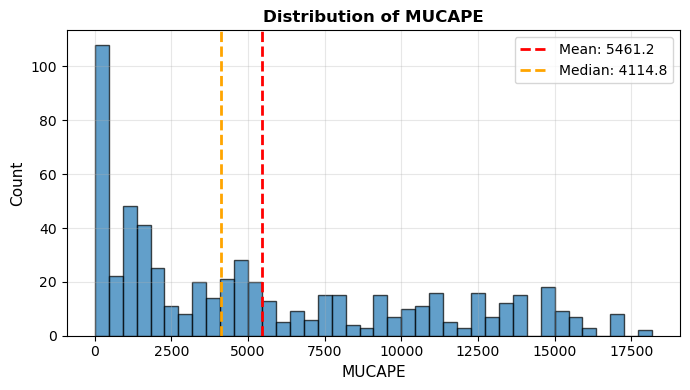

MUCAPE: min=0.0, mean=5461.2, max=18182.3


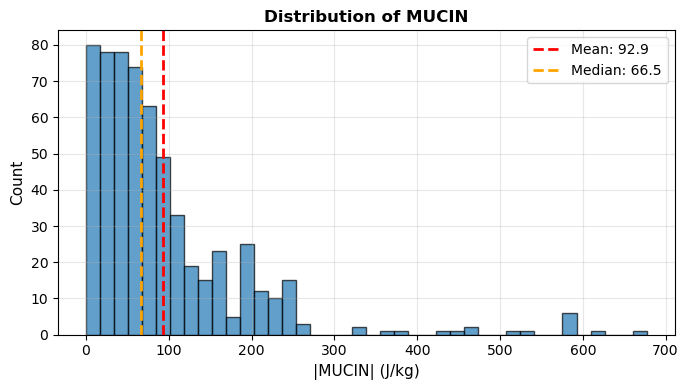

MUCIN: min=0.0, mean=92.9, max=677.0


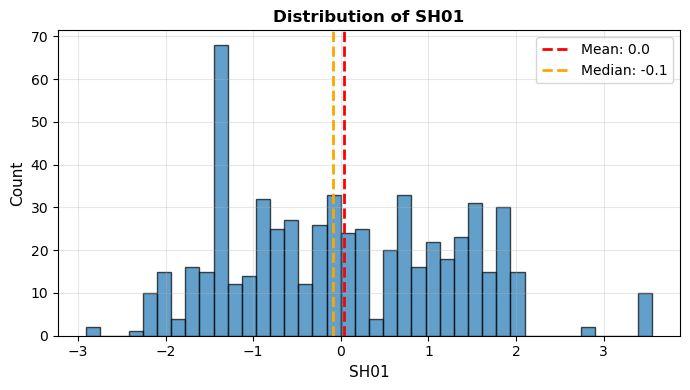

SH01: min=-2.9, mean=0.0, max=3.5


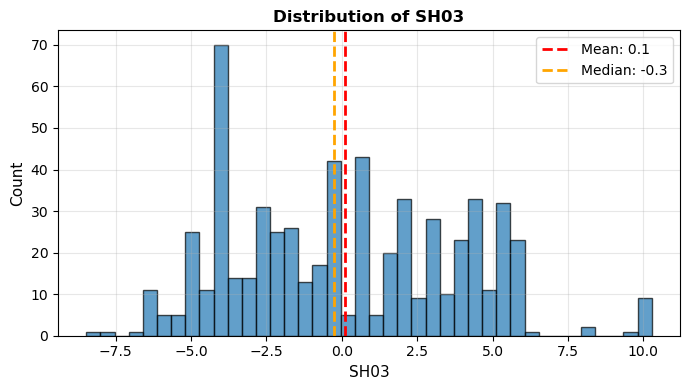

SH03: min=-8.5, mean=0.1, max=10.3


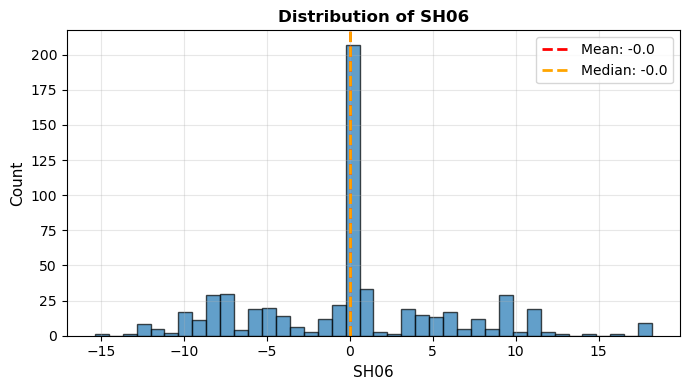

SH06: min=-15.4, mean=-0.0, max=18.2


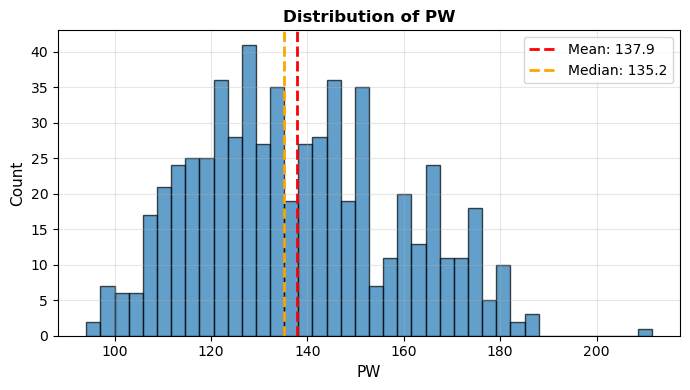

PW: min=94.1, mean=137.9, max=211.4


In [105]:
for col in ['MUCAPE','MUCIN','SH01','SH03','SH06','PW']:
    if col not in df.columns: 
        continue
    vals = np.abs(df[col]) if col=='MUCIN' else df[col]
    vals_clean = vals.dropna()
    
    if len(vals_clean) == 0:
        print(f"No valid data for {col}")
        continue
    
    plt.figure(figsize=(7,4))
    plt.hist(vals_clean.values, bins=40, edgecolor='black', alpha=0.7)
    plt.xlabel(col if col!='MUCIN' else '|MUCIN| (J/kg)', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    plt.grid(alpha=0.3)
    
    # Add statistics
    mean_val = vals_clean.mean()
    median_val = vals_clean.median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"{col}: min={vals_clean.min():.1f}, mean={mean_val:.1f}, max={vals_clean.max():.1f}")

## 2‑D Coverage (hexbin)
Quick maps to see where samples land: **CAPE vs shear**, and **CAPE vs |CIN|**.

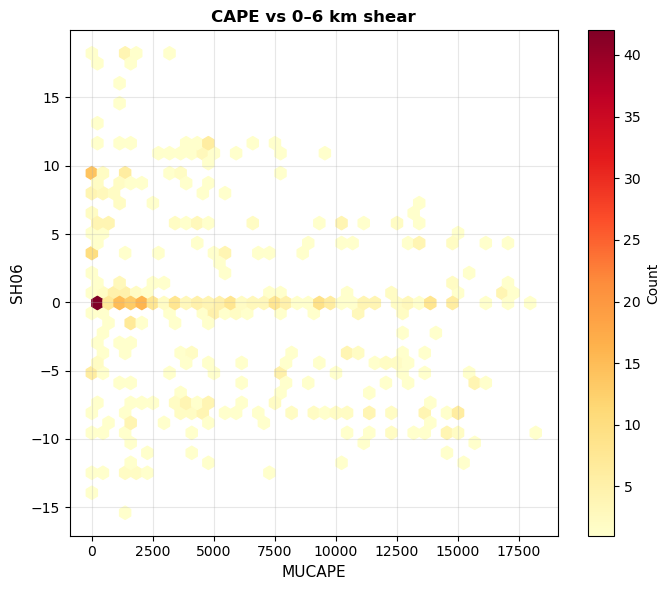

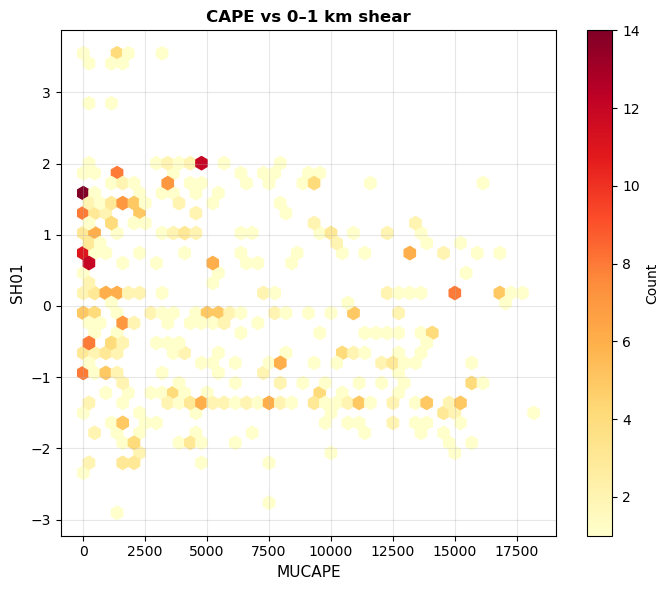

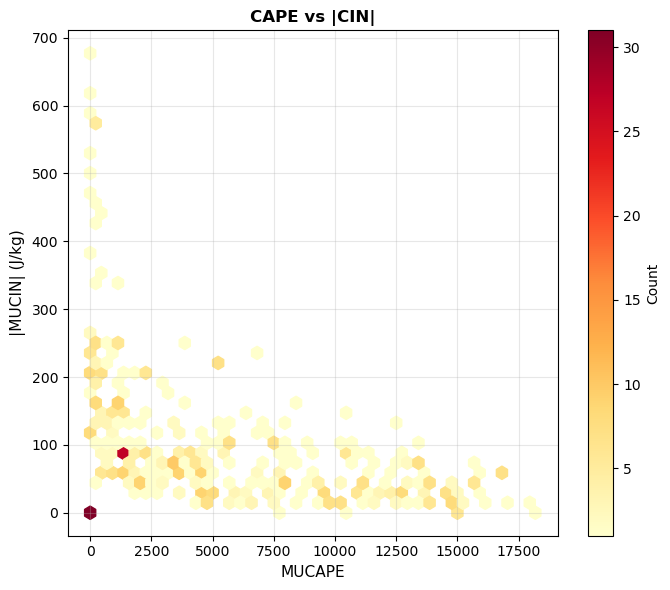

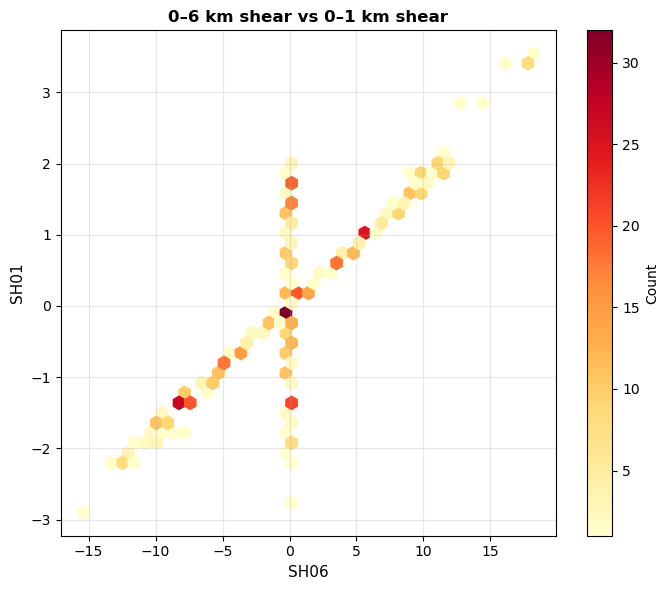

In [106]:
pairs = [
    ('MUCAPE','SH06','CAPE vs 0–6 km shear'),
    ('MUCAPE','SH01','CAPE vs 0–1 km shear'),
    ('MUCAPE','MUCIN','CAPE vs |CIN|'),
    ('SH06','SH01','0–6 km shear vs 0–1 km shear'),
]

for x, y, title in pairs:
    if x not in df or y not in df: 
        continue
    
    xv = df[x].values
    yv = np.abs(df[y].values) if y=='MUCIN' else df[y].values
    
    # Remove NaN
    mask = ~(np.isnan(xv) | np.isnan(yv))
    xv = xv[mask]
    yv = yv[mask]
    
    if len(xv) == 0:
        print(f"No valid data for {title}")
        continue
    
    plt.figure(figsize=(7,6))
    hb = plt.hexbin(xv, yv, gridsize=40, mincnt=1, cmap='YlOrRd')
    plt.xlabel(x if x!='MUCIN' else '|MUCIN| (J/kg)', fontsize=11)
    plt.ylabel(y if y!='MUCIN' else '|MUCIN| (J/kg)', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    cb = plt.colorbar(hb, label='Count')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Binned coverage tables
Adjust bins as needed for your parameter space.

In [107]:
# Define bins
cape_bins = [0, 500, 1000, 2000, 3000, 4000, np.inf]
shear_bins = [0, 10, 15, 20, 25, 30, 40, np.inf]
cin_bins = [0, 25, 50, 75, 100, 150, np.inf]

# Create binned columns
df['CINabs'] = np.abs(df['MUCIN'])
df['CAPE_bin'] = pd.cut(df['MUCAPE'], bins=cape_bins)
df['SH06_bin'] = pd.cut(df['SH06'], bins=shear_bins)
df['CIN_bin'] = pd.cut(df['CINabs'], bins=cin_bins)

# Create pivot tables
print("\n" + "="*60)
print("CAPE vs 0-6 km Shear Coverage")
print("="*60)
pivot_cape_sh06 = df.pivot_table(
    index='CAPE_bin', 
    columns='SH06_bin', 
    values='idx', 
    aggfunc='count',
    observed=False
).fillna(0).astype(int)
print(pivot_cape_sh06)

print("\n" + "="*60)
print("CAPE vs |CIN| Coverage")
print("="*60)
pivot_cape_cin = df.pivot_table(
    index='CAPE_bin', 
    columns='CIN_bin', 
    values='idx', 
    aggfunc='count',
    observed=False
).fillna(0).astype(int)
print(pivot_cape_cin)

# Summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)
total_samples = len(df)
valid_samples = df['MUCAPE'].notna().sum()
print(f"Total samples: {total_samples}")
print(f"Valid samples: {valid_samples} ({valid_samples/total_samples*100:.1f}%)")
print(f"Failed samples: {total_samples - valid_samples}")


CAPE vs 0-6 km Shear Coverage
SH06_bin          (0.0, 10.0]  (10.0, 15.0]  (15.0, 20.0]  (20.0, 25.0]  \
CAPE_bin                                                                  
(0.0, 500.0]               51             2             1             0   
(500.0, 1000.0]            17             0             0             0   
(1000.0, 2000.0]           37             3             7             0   
(2000.0, 3000.0]           18             1             0             0   
(3000.0, 4000.0]           10             3             1             0   
(4000.0, inf]             114            18             0             0   

SH06_bin          (25.0, 30.0]  (30.0, 40.0]  (40.0, inf]  
CAPE_bin                                                   
(0.0, 500.0]                 0             0            0  
(500.0, 1000.0]              0             0            0  
(1000.0, 2000.0]             0             0            0  
(2000.0, 3000.0]             0             0            0  
(3000.0,

## 3D Scatter: CAPE vs Shear vs |CIN|
Visualize the full 3D parameter space coverage.

     idx       MUCAPE       MUCIN      SH01      SH03      SH06          PW  \
0      0    17.071288 -577.761545  1.501232  4.503848  9.007763  135.881824   
1      1  1047.261307 -139.271654  1.501232  4.503848  9.007763  147.931434   
2      2    40.076868 -531.793193  1.501232  4.503848  9.007763  138.572451   
3      3    16.420859 -580.633566  1.501232  4.503848  9.007763  136.078020   
4      4  3925.694130 -246.798223  1.501232  4.503848  9.007763  164.669984   
..   ...          ...         ...       ...       ...       ...         ...   
595  595  7428.677450 -106.837271 -1.382436 -3.994045 -7.012399  128.450772   
596  596  7428.677450 -106.837271 -0.966286 -2.723578  0.009740  128.450772   
597  597  7428.677450 -106.837271 -0.927625 -2.763269  0.009285  128.450772   
598  598  7428.677450 -106.837271 -2.797649 -7.885469  0.028200  128.450772   
599  599  7428.677450 -106.837271 -1.378145 -3.884447  0.013892  128.450772   

         CINabs          CAPE_bin     SH06_bin     

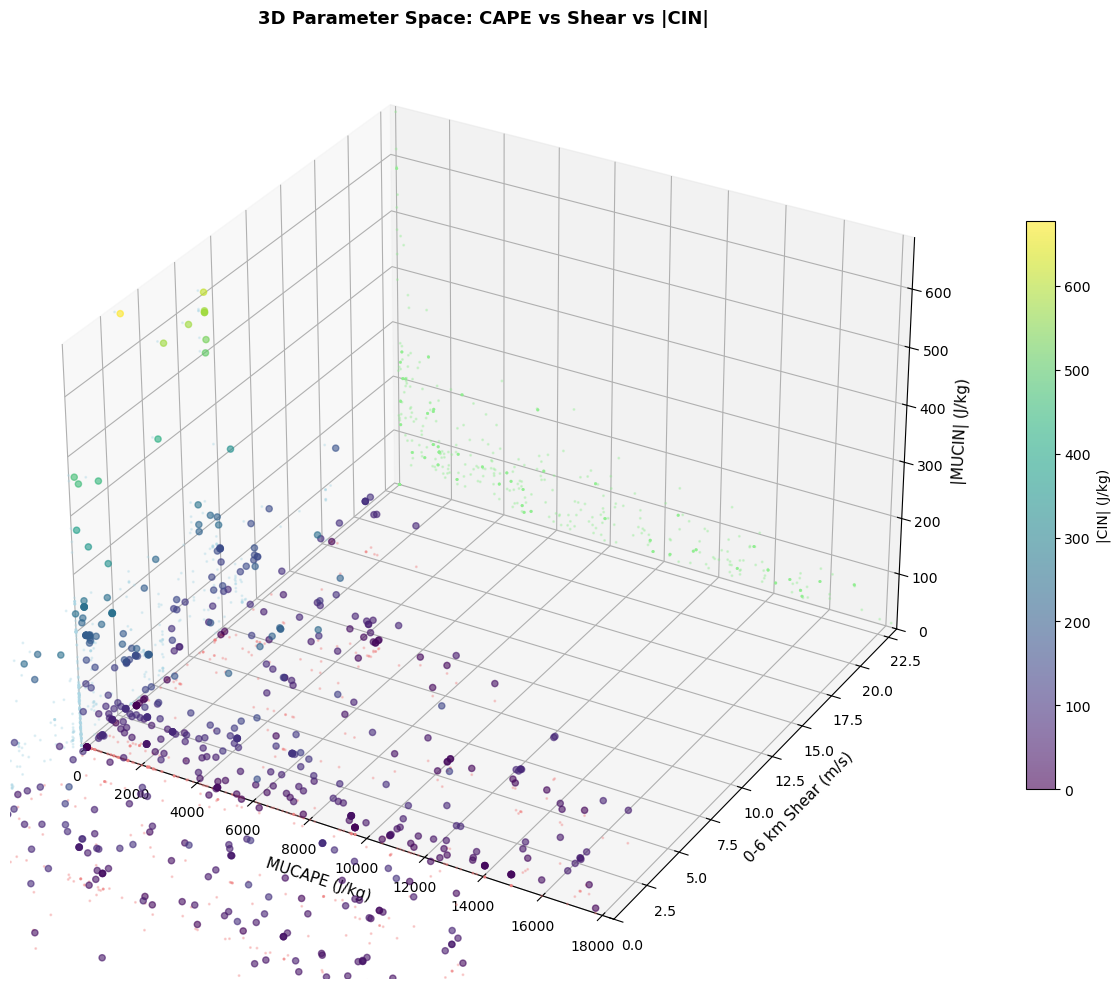

In [108]:
from mpl_toolkits.mplot3d import Axes3D

# Clean data
mask = df['MUCAPE'].notna() & df['SH06'].notna() & df['MUCIN'].notna()
df_clean = df[mask].copy()
print(df_clean)
if len(df_clean) > 0:
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Main 3D scatter
    scatter = ax.scatter(
        df_clean['MUCAPE'], 
        df_clean['SH06'], 
        df_clean['CINabs'],
        c=df_clean['CINabs'], 
        cmap='viridis',
        marker='o', 
        s=20, 
        alpha=0.6
    )
    
    ax.set_xlabel('MUCAPE (J/kg)', fontsize=11)
    ax.set_ylabel('0-6 km Shear (m/s)', fontsize=11)
    ax.set_zlabel('|MUCIN| (J/kg)', fontsize=11)
    ax.set_title('3D Parameter Space: CAPE vs Shear vs |CIN|', fontsize=13, fontweight='bold')
    
    # Set reasonable axis limits
    ax.set_xlim(df_clean['MUCAPE'].min() - 200, df_clean['MUCAPE'].max() + 200)
    ax.set_ylim(0, df_clean['SH06'].max() + 5)
    ax.set_zlim(0, df_clean['CINabs'].max() + 10)
    
    # Projections on walls
    ax.scatter(
        df_clean['MUCAPE'], 
        df_clean['SH06'], 
        zs=0, 
        zdir='z', 
        c='lightcoral', 
        marker='.', 
        s=5, 
        alpha=0.3
    )
    ax.scatter(
        df_clean['MUCAPE'], 
        zs=df_clean['SH06'].max() + 5, 
        zdir='y', 
        ys=df_clean['CINabs'], 
        c='lightgreen', 
        marker='.', 
        s=5, 
        alpha=0.3
    )
    ax.scatter(
        zs=df_clean['MUCAPE'].min() - 200, 
        zdir='x', 
        xs=df_clean['SH06'], 
        ys=df_clean['CINabs'], 
        c='lightblue', 
        marker='.', 
        s=5, 
        alpha=0.3
    )
    
    plt.colorbar(scatter, label='|CIN| (J/kg)', shrink=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No valid data for 3D plot")

## Analysis Summary
Key metrics and coverage assessment.

In [109]:
print("="*70)
print("PARAMETER SPACE COVERAGE SUMMARY")
print("="*70)

valid_df = df.dropna(subset=['MUCAPE', 'MUCIN', 'SH06'])

if len(valid_df) > 0:
    print(f"\nValid samples: {len(valid_df)}")
    print("\nParameter Ranges:")
    print("-"*70)
    
    params = [
        ('MUCAPE', 'J/kg'),
        ('|MUCIN|', 'J/kg'),
        ('0-1 km Shear', 'm/s'),
        ('0-6 km Shear', 'm/s'),
        ('Precip Water', 'mm')
    ]
    
    cols = ['MUCAPE', 'CINabs', 'SH01', 'SH06', 'PW']
    
    for (name, unit), col in zip(params, cols):
        if col in valid_df.columns:
            vals = valid_df[col]
            print(f"{name:20s}: {vals.min():7.1f} to {vals.max():7.1f} {unit:6s} "
                  f"(mean: {vals.mean():7.1f})")
    
    # Identify potentially interesting cases
    print("\n" + "-"*70)
    print("Potentially Interesting Cases:")
    print("-"*70)
    
    high_cape_high_shear = valid_df[(valid_df['MUCAPE'] > 2000) & (valid_df['SH06'] > 20)]
    low_cin = valid_df[valid_df['CINabs'] < 25]
    extreme_shear = valid_df[valid_df['SH06'] > 30]
    
    print(f"High CAPE + High Shear (>2000 J/kg, >20 m/s): {len(high_cape_high_shear)} samples")
    print(f"Low CIN (<25 J/kg): {len(low_cin)} samples")
    print(f"Extreme shear (>30 m/s): {len(extreme_shear)} samples")
    
    print("\n" + "="*70)
else:
    print("No valid samples to analyze!")

PARAMETER SPACE COVERAGE SUMMARY

Valid samples: 600

Parameter Ranges:
----------------------------------------------------------------------
MUCAPE              :     0.0 to 18182.3 J/kg   (mean:  5461.2)
|MUCIN|             :     0.0 to   677.0 J/kg   (mean:    92.9)
0-1 km Shear        :    -2.9 to     3.5 m/s    (mean:     0.0)
0-6 km Shear        :   -15.4 to    18.2 m/s    (mean:    -0.0)
Precip Water        :    94.1 to   211.4 mm     (mean:   137.9)

----------------------------------------------------------------------
Potentially Interesting Cases:
----------------------------------------------------------------------
High CAPE + High Shear (>2000 J/kg, >20 m/s): 0 samples
Low CIN (<25 J/kg): 108 samples
Extreme shear (>30 m/s): 0 samples



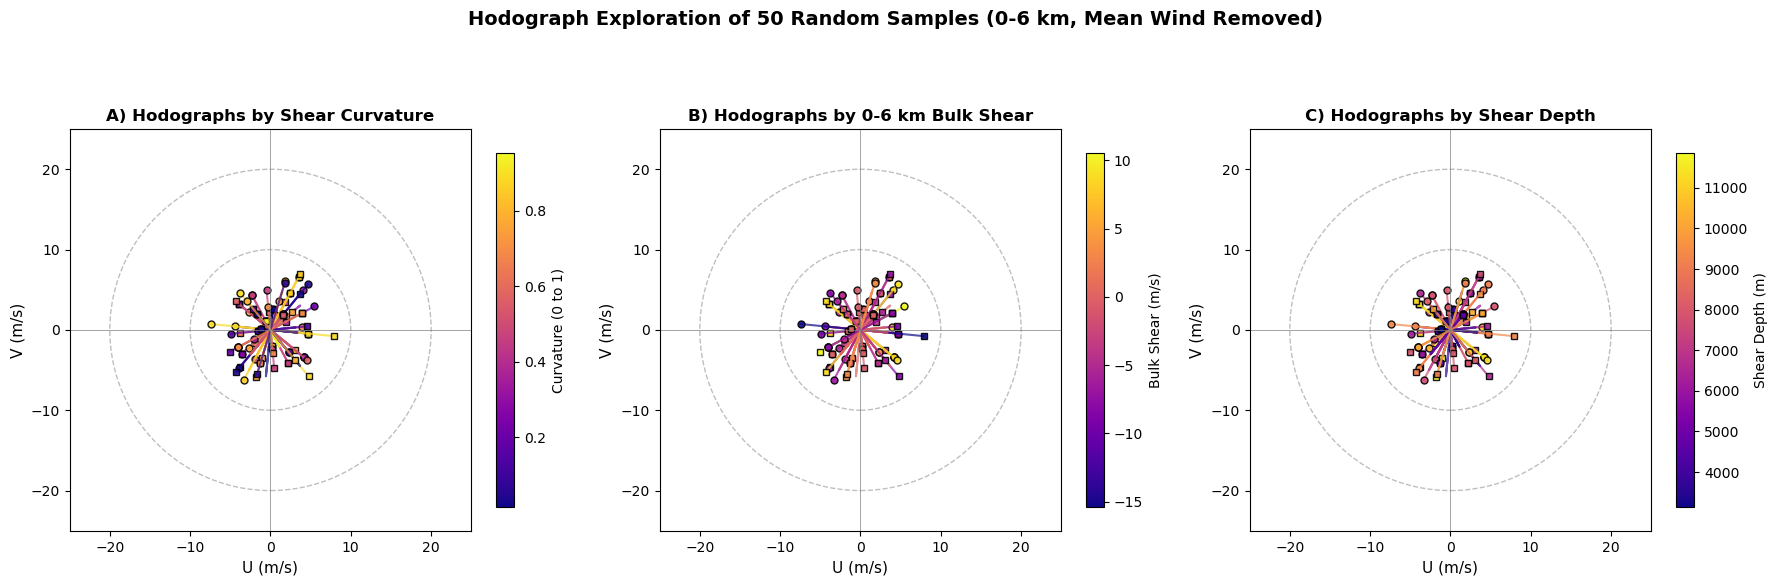

In [110]:
import numpy as np
import pickle
import glob
import os
import matplotlib.pyplot as plt
from metpy.units import units
import metpy.calc as mpcalc
from pathlib import Path
import sys

# Add src to path if running from a notebook/script in a subdirectory
REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.insert(0, str(SRC))

# Import required functions (assuming read_input_sounding is available in sounding_generator.py)
from sounding_generator import read_input_sounding, generate_sounding

# --- CONFIGURATION ---
# Assumes Step 1 and Step 2 have been run with the new 12-parameter setup.
EXPERIMENT_DIR = f'{REPO_ROOT}/outputs/sobol_exp_500' 
SOUNDINGS_DIR = f'{EXPERIMENT_DIR}/soundings'
BASE_SOUNDING = f'{REPO_ROOT}/src/input_sounding' 
N_TO_PLOT = 50 # Plot a random subset of 50 samples for visualization

# --- LOAD SAMPLES AND SELECT SUBSET ---
# Load all generated sounding file paths
all_sounding_paths = sorted(glob.glob(os.path.join(SOUNDINGS_DIR, 'input_sounding_*')))
if not all_sounding_paths:
    raise FileNotFoundError(f"No soundings found in {SOUNDINGS_DIR}. Did you run step2_generate_soundings.py?")

# Load the parameter data to get input values for coloring
param_values = np.load(f'{EXPERIMENT_DIR}/param_values.npy')
with open(f'{EXPERIMENT_DIR}/problem.pkl', 'rb') as f:
    problem = pickle.load(f)

# Select a random subset of indices from the generated soundings
np.random.seed(42) 
total_samples = len(all_sounding_paths)
sample_indices_to_plot = np.random.choice(total_samples, N_TO_PLOT, replace=False)
soundings_to_plot = [all_sounding_paths[i] for i in sample_indices_to_plot]

# --- PROCESS SOUNDINGS AND COLLECT HODOGRAPHS ---
hodographs = []
param_subset = []
metpy_diagnostics = []

for idx, input_sounding_path in enumerate(soundings_to_plot):
    # Determine the original Sobol sample index (e.g., from 'input_sounding_00055')
    sample_id = int(os.path.basename(input_sounding_path).split('_')[-1])
    
    try:
        # 1. Read the WRF-formatted sounding file
        sounding = read_input_sounding(input_sounding_path)

        # 2. Extract input parameters for coloring (from the param_values array)
        param_dict = dict(zip(problem['names'], param_values[sample_id]))
        
        # 3. Prepare data for MetPy calculations and plotting
        z = sounding['height'] * units.meter
        u = sounding['u'] * units('m/s')
        v = sounding['v'] * units('m/s')

        # Define 0-6 km level for hodograph trace and bulk shear
        z_target = 6000 * units.meter
        mask = z <= z_target
        
        # Calculate 0-6 km Bulk Shear (U_max, since mean wind is removed)
        # Note: bulk_shear returns a magnitude array, we take the first element (the magnitude)
        bulk_shear_0_6 = mpcalc.bulk_shear(sounding['p'] * units.hPa, u, v, height=z, depth=z_target)[0]

        hodographs.append({
            'u': u[mask].to('m/s').m,
            'v': v[mask].to('m/s').m,
            'z': z[mask].to('km').m,
        })
        
        param_subset.append({
            'shear_curvature': param_dict['shear_curvature'],
            'shear_rate': param_dict['shear_rate'],
            'shear_depth': param_dict['shear_depth'],
            'bulk_shear_0_6': bulk_shear_0_6.to('m/s').m
        })
        
    except Exception as e:
        print(f"Skipping sample {sample_id} from file {os.path.basename(input_sounding_path)} due to error: {e}")
        continue

# Extract parameters for coloring the plot
shear_curvatures = np.array([p['shear_curvature'] for p in param_subset])
shear_rates_inv = 1.0 / np.array([p['shear_rate'] for p in param_subset]) # Use 1/S (scale factor) for clearer visualization
shear_depths = np.array([p['shear_depth'] for p in param_subset])
bulk_shear_0_6 = np.array([p['bulk_shear_0_6'] for p in param_subset])


# --- PLOTTING FUNCTIONS ---
def plot_hodograph_panel(ax, title, color_by_param, cmap_label):
    """Generic function to plot hodographs and color by a parameter."""
    
    # Calculate color map for the chosen parameter
    cmap = plt.cm.plasma
    norm = plt.Normalize(vmin=np.min(color_by_param), vmax=np.max(color_by_param))
    
    for h, param_val in zip(hodographs, color_by_param):
        color = cmap(norm(param_val))
        # Plot hodograph trace (0-6 km)
        ax.plot(h['u'], h['v'], color=color, alpha=0.7, linewidth=1.5)
        # Plot 6 km endpoint
        ax.plot(h['u'][-1], h['v'][-1], 'o', color=color, markersize=5, markeredgecolor='black', alpha=0.9) 
        # Plot surface point
        ax.plot(h['u'][0], h['v'][0], 's', color=color, markersize=5, markeredgecolor='black', alpha=0.9) 
        
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label(cmap_label, fontsize=10)

    # Add reference rings
    ax.add_patch(plt.Circle((0, 0), 10, color='gray', fill=False, linestyle='--', alpha=0.5))
    ax.add_patch(plt.Circle((0, 0), 20, color='gray', fill=False, linestyle='--', alpha=0.5))
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlabel('U (m/s)', fontsize=11)
    ax.set_ylabel('V (m/s)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    
# --- PLOTTING ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel A: Colored by Shear Curvature (0 to 1)
plot_hodograph_panel(axes[0], 'A) Hodographs by Shear Curvature', shear_curvatures, 'Curvature (0 to 1)')

# Panel B: Colored by Bulk Shear (0-6 km U_max)
plot_hodograph_panel(axes[1], 'B) Hodographs by 0-6 km Bulk Shear', bulk_shear_0_6, 'Bulk Shear (m/s)')

# Panel C: Colored by Shear Depth (D_shear)
plot_hodograph_panel(axes[2], 'C) Hodographs by Shear Depth', shear_depths, 'Shear Depth (m)')

plt.suptitle(f'Hodograph Exploration of {N_TO_PLOT} Random Samples (0-6 km, Mean Wind Removed)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
plt.show()
